# Problem 5.2: Covid-19 tests - data reader

The following is a small program to read the data file "data_Covid19tests.txt", which contains three column: Date (in January 2021), Number of (PCR) tests on that day, and number of positive tests that day.

### Author & Date: 
- Troels C. Petersen (Niels Bohr Institute)
- 07-11-2021

***

In [1]:
# Read the data and print it to check it:
import numpy as np
import matplotlib.pyplot as plt

from ExternalFunctions import Chi2Regression

from scipy import stats
from iminuit import Minuit

In [2]:
date, Ntests, Npositives = np.loadtxt("data_Covid19tests.txt", skiprows=2, unpack=True)

print("Number of entries: ", len(date))
for i in range(len(date)) : 
    print(f"  {date[i]:2.0f}  {Ntests[i]:6.0f}  {Npositives[i]:5.0f}")

Number of entries:  15
   4  103270   2464
   5  102145   1920
   6   93981   1647
   7   83748   1573
   8   73944   1428
   9   51387   1192
  10   47092    989
  11   79306   1340
  12   83126   1238
  13   76080   1112
  14  103694    998
  15   97416    844
  16   75592    719
  17   73613    670
  18  101957    882


In [3]:
def calculate_weighted_mean(data, uncertainties):
    return np.sum(data/uncertainties**2)/np.sum(1./uncertainties**2)

def calculate_uncertainty(uncertainties):
    return np.sqrt(1./np.sum(1./uncertainties**2))

83090.06666666667


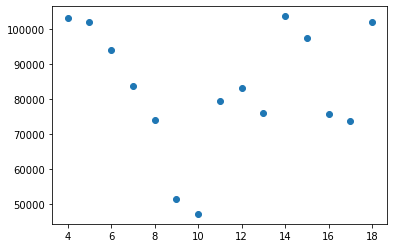

In [4]:
mean_Ntests = np.sum(Ntests)/len(Ntests)
mean_Npositives = np.sum(Npositives)/len(Npositives)
print(mean_Ntests)
plt.scatter(date,Ntests)
plt.show()

In [5]:
scaled_positives = Npositives * (Ntests/mean_Ntests)**(-0.7)

In [6]:
def SP_func_1(t, SP0, R, t0):
    tG=4.7
    return SP0 * R**((t-t0)/tG)

def do_a_chi2_fit(x_data, y_data, sigma_y_data, f, init_guess, verbose=True):
    """Does a chi2 fit, plots results and returns the minuit output
    init_guess needs to have the initial fit parameters in a list format (e.g. [a,b,c])"""
    chi2 = Chi2Regression(f, x_data, y_data, sigma_y_data)
    chi2.errordef = 1
    minuit_chi2 = Minuit(chi2, *init_guess) #   
    if verbose:
        display(minuit_chi2.migrad())          # Perform the actual fit
    else:
        minuit_chi2.migrad();

    # Get number of degrees-of-freedom (Ndof):
    Ndof_value = len(x_data) - minuit_chi2.nfit

    chi2_value = minuit_chi2.fval
    p_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
    if verbose:
        print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {p_value:5.10f}")

    return minuit_chi2, Ndof_value, p_value

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 20.78                      │              Nfcn = 84               │
│ EDM = 6.69e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ SP0  │   3.2e3   │   1.0e3   │            │            │         │         │       │
│ 1 │ R    │   0.723   │   0.020   │            │            │         │         │       │
│ 2 │ t0   │    -3     │     5     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬───────────────────────────────┐
│     │       SP0         R        t0 │
├─────┼───────────────────────────────┤
│ SP0 │     1e+06     -2.07 -4.42e+03 │
│   R │     -2.07  0.000394  -0.00997 │
│  t0 │ -4.42e+03  -0.00997      20.6 │
└─────┴───────────────────────────────┘

Chi2 value: 20.8   Ndof = 12    Prob(Chi2,Ndof) = 0.0536209661


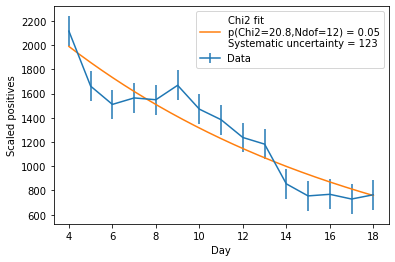

In [7]:
# Do a chi2 fit
forced_sigma_SP = 123
minuit_chi2, Ndof_value, p_value = do_a_chi2_fit(date, scaled_positives, forced_sigma_SP, SP_func_1, [10000, 0.5, 0])

# Plot
x_axis = np.linspace(np.min(date), np.max(date), 1000)
y_axis = SP_func_1(x_axis,*minuit_chi2.values)

fig2, ax2 = plt.subplots()
ax2.errorbar(date, scaled_positives, yerr=forced_sigma_SP, label='Data')
label_string = f'Chi2 fit\n' + \
            f'p(Chi2={minuit_chi2.fval:.1f},Ndof={Ndof_value:d}) = {p_value:.2f}\n' + \
            f'Systematic uncertainty = {forced_sigma_SP}'
ax2.plot(x_axis, y_axis,label=label_string)

ax2.set_xlabel(r'Day')
ax2.set_ylabel(r'Scaled positives')

#ax2.set_xscale('log')
#ax2.set_yscale('log')

ax2.legend()

plt.savefig('Problem_5.2.png',dpi=600)

In [8]:
# Simulate the uncertainty on tG
def SP_func_2(t, SP0, R, t0):
    global tG # Totally not dangerous to do, nope, not at all
    return SP0 * R**((t-t0)/tG)

Loop 0


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 20.78                      │              Nfcn = 100              │
│ EDM = 2e-07 (Goal: 0.0002)       │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ SP0  │   3.3e3   │   1.0e3   │            │            │         │         │       │
│ 1 │ R    │   0.668   │   0.023   │            │            │         │         │       │
│ 2 │ t0   │    -3     │     5     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬───────────────────────────────┐
│     │       SP0         R        t0 │
├─────┼───────────────────────────────┤
│ SP0 │  1.06e+06     -2.71 -4.54e+03 │
│   R │     -2.71  0.000521   -0.0111 │
│  t0 │ -4.54e+03   -0.0111      20.5 │
└─────┴───────────────────────────────┘

Chi2 value: 20.8   Ndof = 12    Prob(Chi2,Ndof) = 0.0536220229


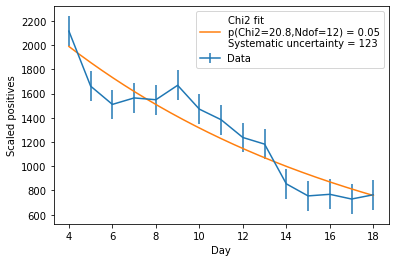

Loop 1


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 20.78                      │              Nfcn = 100              │
│ EDM = 2.02e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ SP0  │   3.3e3   │   1.0e3   │            │            │         │         │       │
│ 1 │ R    │   0.668   │   0.023   │            │            │         │         │       │
│ 2 │ t0   │    -3     │     5     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬───────────────────────────────┐
│     │       SP0         R        t0 │
├─────┼───────────────────────────────┤
│ SP0 │  1.06e+06     -2.71 -4.54e+03 │
│   R │     -2.71  0.000521   -0.0111 │
│  t0 │ -4.54e+03   -0.0111      20.5 │
└─────┴───────────────────────────────┘

Chi2 value: 20.8   Ndof = 12    Prob(Chi2,Ndof) = 0.0536220229


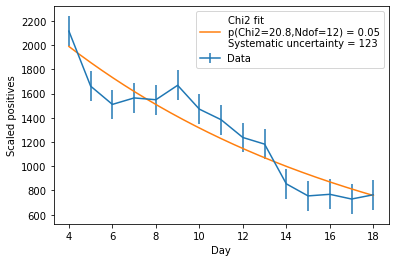

Loop 2


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 20.78                      │              Nfcn = 87               │
│ EDM = 2.52e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ SP0  │   3.2e3   │   1.0e3   │            │            │         │         │       │
│ 1 │ R    │   0.743   │   0.019   │            │            │         │         │       │
│ 2 │ t0   │    -3     │     5     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬────────────────────────────┐
│     │      SP0        R       t0 │
├─────┼────────────────────────────┤
│ SP0 │ 9.95e+05    -2.08 -4.4e+03 │
│   R │    -2.08  0.00035 -0.00868 │
│  t0 │ -4.4e+03 -0.00868     20.5 │
└─────┴────────────────────────────┘

Chi2 value: 20.8   Ndof = 12    Prob(Chi2,Ndof) = 0.0536220222


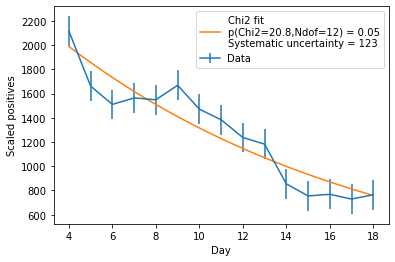

Loop 3


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 20.78                      │              Nfcn = 93               │
│ EDM = 2.38e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ SP0  │   3.2e3   │   1.0e3   │            │            │         │         │       │
│ 1 │ R    │   0.747   │   0.018   │            │            │         │         │       │
│ 2 │ t0   │    -3     │     5     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬────────────────────────────┐
│     │      SP0        R       t0 │
├─────┼────────────────────────────┤
│ SP0 │ 9.93e+05    -2.04 -4.4e+03 │
│   R │    -2.04 0.000342 -0.00863 │
│  t0 │ -4.4e+03 -0.00863     20.5 │
└─────┴────────────────────────────┘

Chi2 value: 20.8   Ndof = 12    Prob(Chi2,Ndof) = 0.0536220257


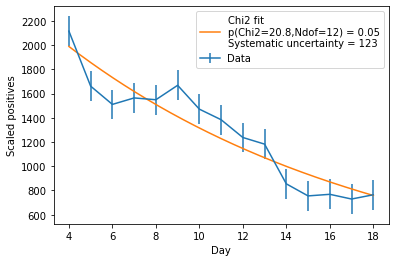

Loop 4


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 20.78                      │              Nfcn = 100              │
│ EDM = 3.93e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ SP0  │   3.5e3   │   1.1e3   │            │            │         │         │       │
│ 1 │ R    │   0.583   │   0.027   │            │            │         │         │       │
│ 2 │ t0   │    -4     │     5     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬────────────────────────────┐
│     │      SP0        R       t0 │
├─────┼────────────────────────────┤
│ SP0 │  1.2e+06    -3.54 -4.8e+03 │
│   R │    -3.54 0.000705   -0.014 │
│  t0 │ -4.8e+03   -0.014     20.5 │
└─────┴────────────────────────────┘

Chi2 value: 20.8   Ndof = 12    Prob(Chi2,Ndof) = 0.0536220199


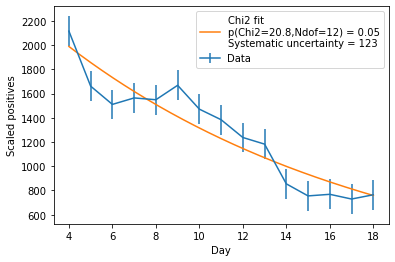

Loop 5
Loop 6
Loop 7
Loop 8
Loop 9
Loop 10
Loop 11
Loop 12
Loop 13
Loop 14
Loop 15
Loop 16
Loop 17
Loop 18
Loop 19
Loop 20
Loop 21
Loop 22
Loop 23
Loop 24
Loop 25
Loop 26
Loop 27
Loop 28
Loop 29
Loop 30
Loop 31
Loop 32
Loop 33
Loop 34
Loop 35
Loop 36
Loop 37
Loop 38
Loop 39
Loop 40
Loop 41
Loop 42
Loop 43
Loop 44
Loop 45
Loop 46
Loop 47
Loop 48
Loop 49
Loop 50
Loop 51
Loop 52
Loop 53
Loop 54
Loop 55
Loop 56
Loop 57
Loop 58
Loop 59
Loop 60
Loop 61
Loop 62
Loop 63
Loop 64
Loop 65
Loop 66
Loop 67
Loop 68
Loop 69
Loop 70
Loop 71
Loop 72
Loop 73
Loop 74
Loop 75
Loop 76
Loop 77
Loop 78
Loop 79
Loop 80
Loop 81
Loop 82
Loop 83
Loop 84
Loop 85
Loop 86
Loop 87
Loop 88
Loop 89
Loop 90
Loop 91
Loop 92
Loop 93
Loop 94
Loop 95
Loop 96
Loop 97
Loop 98
Loop 99
Loop 100
Loop 101
Loop 102
Loop 103
Loop 104
Loop 105
Loop 106
Loop 107
Loop 108
Loop 109
Loop 110
Loop 111
Loop 112
Loop 113
Loop 114
Loop 115
Loop 116
Loop 117
Loop 118
Loop 119
Loop 120
Loop 121
Loop 122
Loop 123
Loop 124
Loop 125
Loop 126
Lo

Loop 943
Loop 944
Loop 945
Loop 946
Loop 947
Loop 948
Loop 949
Loop 950
Loop 951
Loop 952
Loop 953
Loop 954
Loop 955
Loop 956
Loop 957
Loop 958
Loop 959
Loop 960
Loop 961
Loop 962
Loop 963
Loop 964
Loop 965
Loop 966
Loop 967
Loop 968
Loop 969
Loop 970
Loop 971
Loop 972
Loop 973
Loop 974
Loop 975
Loop 976
Loop 977
Loop 978
Loop 979
Loop 980
Loop 981
Loop 982
Loop 983
Loop 984
Loop 985
Loop 986
Loop 987
Loop 988
Loop 989
Loop 990
Loop 991
Loop 992
Loop 993
Loop 994
Loop 995
Loop 996
Loop 997
Loop 998
Loop 999
[0.66760516 0.66775374 0.74281417 0.74656875 0.58264856 0.6812594
 0.69339308 0.72808732 0.80055644 0.64125118 0.72324584 0.63644446
 0.71564071 0.71932378 0.70907091 0.82838869 0.69902148 0.6770318
 0.7659772  0.68391086 0.73940232 0.62878548 0.63671327 0.72688611
 0.82980774 0.64689689 0.76983326 0.69915035 0.69443622 0.66273224
 0.70493985 0.81535515 0.76308699 0.67259982 0.70170627 0.65791297
 0.64406616 0.70936408 0.65947635 0.78226779 0.72570172 0.71262787
 0.71269808 0.858760

In [10]:
N_trials = 1000 # Number of different tG's that will be tested
forced_sigma_SP = 123

R_values = np.zeros(N_trials)
for i in range(N_trials):
    print(f'Loop {i}')
    tG = np.random.normal(loc=4.7,scale=1.0) # Randomly choose a value for tG
    
    # Plot the first 5
    if i < 5:
        # Do a chi2 fit
        minuit_chi2, Ndof_value, p_value = do_a_chi2_fit(date, scaled_positives, forced_sigma_SP, SP_func_2, [10000, 0.5, 0])
        
        
        x_axis = np.linspace(np.min(date), np.max(date), 1000)
        y_axis = SP_func_2(x_axis,*minuit_chi2.values)

        fig2, ax2 = plt.subplots()
        ax2.errorbar(date, scaled_positives, yerr=forced_sigma_SP, label='Data')
        label_string = f'Chi2 fit\n' + \
                    f'p(Chi2={minuit_chi2.fval:.1f},Ndof={Ndof_value:d}) = {p_value:.2f}\n' + \
                    f'Systematic uncertainty = {forced_sigma_SP}'
        ax2.plot(x_axis, y_axis,label=label_string)

        ax2.set_xlabel(r'Day')
        ax2.set_ylabel(r'Scaled positives')

        #ax2.set_xscale('log')
        #ax2.set_yscale('log')

        ax2.legend()

        plt.show()
    else:
        minuit_chi2, Ndof_value, p_value = do_a_chi2_fit(date, scaled_positives, forced_sigma_SP, SP_func_2, [10000, 0.5, 0], verbose=False)
    
    R_values[i] = minuit_chi2.values[1]
print(R_values)


In [12]:
print(f'R = {np.mean(R_values):.3f} +- {np.std(R_values):.3f}')

R = 0.723 +- 0.049
